# Урок 8. GAN

## Домашнее задание:



1.   Обучите VAE на Fashion MNIST
2.   Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?



In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
def get_encoder(latent_dim=2):
  encoder_inputs = keras.Input(shape=(28, 28, 1))
  x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
  x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(16, activation="relu")(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
  encoder.summary()
  return encoder

In [4]:
def get_decoder(latent_dim=2):
  latent_inputs = keras.Input(shape=(latent_dim,))
  x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
  x = layers.Reshape((7, 7, 64))(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
  decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
  decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
  decoder.summary()
  return decoder

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Загрузим fashion_mnist и объеденим трейн и тест:

In [6]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist_clothes = np.concatenate([x_train, x_test], axis=0)
mnist_clothes = np.expand_dims(mnist_clothes, -1).astype("float32") / 255

4431872/4422102 [==============================] - 0s 0us/step


Попробуем обучить VAE для размерности 2 (чтобы смотреть красивые картинки =))

In [ ]:
latent_dim = 2
encoder = get_encoder(latent_dim=latent_dim)
decoder = get_decoder(latent_dim=latent_dim)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_clothes, epochs=10, batch_size=128)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

Следующая ячейка прогонялась несколько раз, пока лосс не перестал существенно понижаться.

In [ ]:
vae.fit(mnist_clothes, epochs=10, batch_size=512)

Epoch 1/10
137/137 [==============================] - 9s 61ms/step - loss: 257.3081 - reconstruction_loss: 253.6006 - kl_loss: 3.7075
Epoch 2/10
137/137 [==============================] - 8s 60ms/step - loss: 257.1310 - reconstruction_loss: 253.4275 - kl_loss: 3.7035
Epoch 3/10
137/137 [==============================] - 8s 59ms/step - loss: 257.0664 - reconstruction_loss: 253.3654 - kl_loss: 3.7010
Epoch 4/10
137/137 [==============================] - 8s 59ms/step - loss: 256.9630 - reconstruction_loss: 253.2499 - kl_loss: 3.7131
Epoch 5/10
137/137 [==============================] - 8s 59ms/step - loss: 256.9388 - reconstruction_loss: 253.2355 - kl_loss: 3.7034
Epoch 6/10
137/137 [==============================] - 8s 59ms/step - loss: 256.9461 - reconstruction_loss: 253.2395 - kl_loss: 3.7067
Epoch 7/10
137/137 [==============================] - 8s 59ms/step - loss: 256.7738 - reconstruction_loss: 253.0651 - kl_loss: 3.7086
Epoch 8/10
137/137 [==============================] - 8s 59ms/

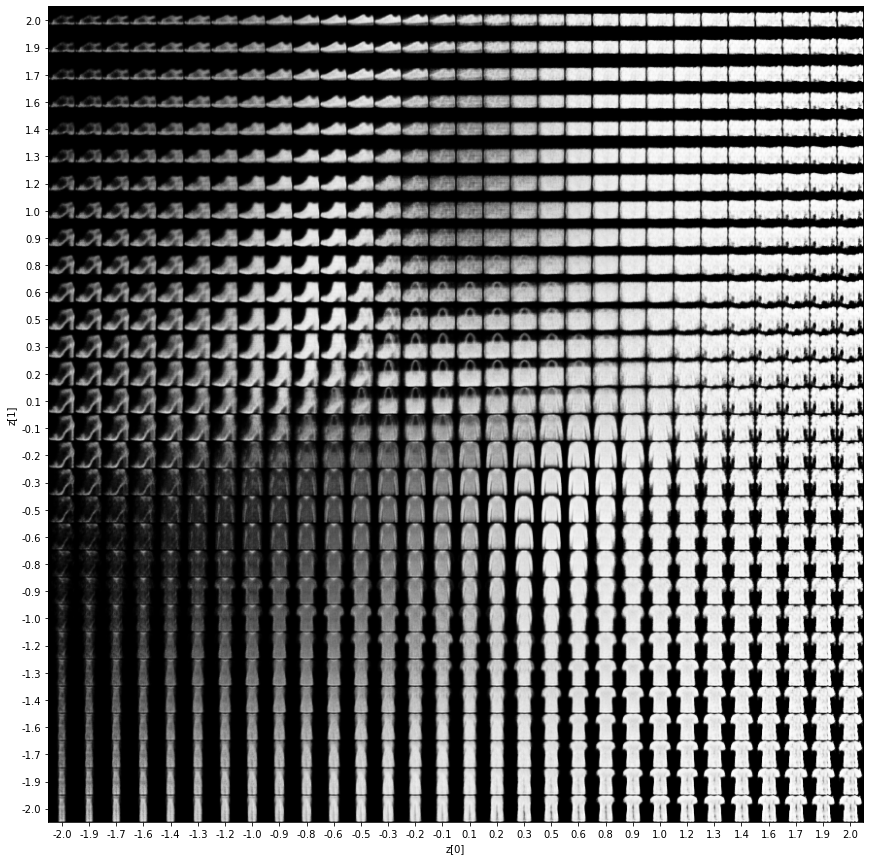

In [ ]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)


Удивительно, но даже на fashion_mnist VAE хватило размерности 2 для того, чтобы уловить основные особенности вероятностного распределения изображений объектов одежды!

Посмотрим на распределение средних:

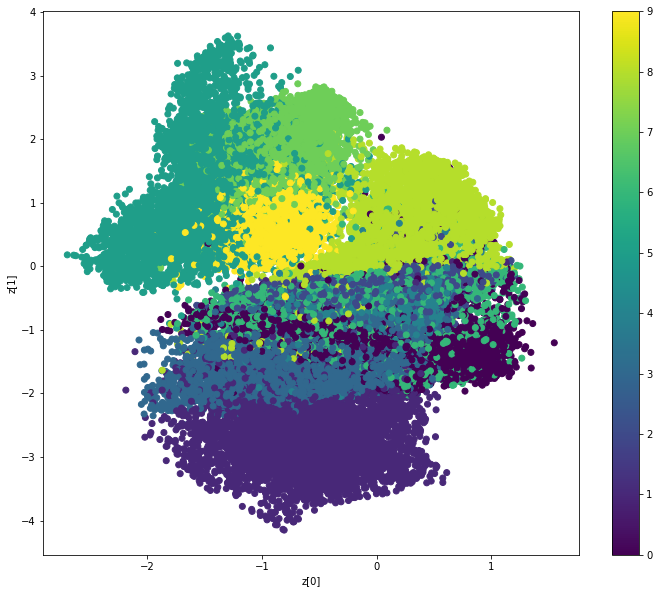

In [ ]:

def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)

0: T-shirt/top

1: Trouser

2: Pullover

3: Dress

4: Coat

5: Sandal

6: Shirt

7: Sneaker

8: Bag

9: Ankle boot

Как видно, многие классы отчетливо выделяются в отдельные блоки. Несколько классов довольно сильно смешиваются, и в целом это похоже на матрицу ошибок классификации в одном из прошлых уроков.

Теперь обучим VAE для размерности 3 и 4:

In [7]:
latent_dim = 3
encoder = get_encoder(latent_dim=latent_dim)
decoder = get_decoder(latent_dim=latent_dim)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [12]:
vae.fit(mnist_clothes, epochs=10, batch_size=512)

Epoch 1/10
137/137 [==============================] - 4s 26ms/step - loss: 244.2871 - reconstruction_loss: 240.5154 - kl_loss: 3.7717
Epoch 2/10
137/137 [==============================] - 3s 25ms/step - loss: 244.2599 - reconstruction_loss: 240.5015 - kl_loss: 3.7584
Epoch 3/10
137/137 [==============================] - 4s 26ms/step - loss: 244.1589 - reconstruction_loss: 240.4008 - kl_loss: 3.7581
Epoch 4/10
137/137 [==============================] - 4s 26ms/step - loss: 244.1545 - reconstruction_loss: 240.3991 - kl_loss: 3.7554
Epoch 5/10
137/137 [==============================] - 4s 26ms/step - loss: 244.0934 - reconstruction_loss: 240.3379 - kl_loss: 3.7555
Epoch 6/10
137/137 [==============================] - 4s 26ms/step - loss: 244.0868 - reconstruction_loss: 240.3356 - kl_loss: 3.7512
Epoch 7/10
137/137 [==============================] - 4s 26ms/step - loss: 243.9427 - reconstruction_loss: 240.1851 - kl_loss: 3.7576
Epoch 8/10
137/137 [==============================] - 4s 26ms/

Судя по лоссу, с размерностью 3 модель обучилась намного лучше. Посмотрим несколько генераций модели:

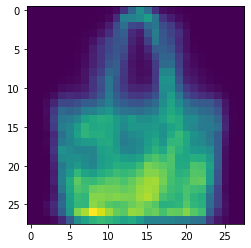

In [25]:
x_decoded = decoder.predict([[0, 0, 0]])
plt.imshow(x_decoded[0,:,:,0] )
plt.show()

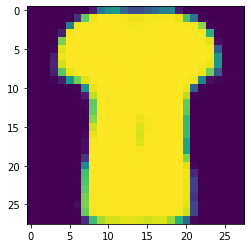

In [26]:
x_decoded = decoder.predict([[2, -2, -2]])
plt.imshow(x_decoded[0,:,:,0] )
plt.show()

Генерации выглядят довольно хорошо.

In [40]:
latent_dim = 4
encoder = get_encoder(latent_dim=latent_dim)
decoder = get_decoder(latent_dim=latent_dim)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_3[0][0]']               
                                                                                            

In [46]:
vae.fit(mnist_clothes, epochs=10, batch_size=1024)

Epoch 1/10
69/69 [==============================] - 3s 49ms/step - loss: 293.2561 - reconstruction_loss: 291.2159 - kl_loss: 2.0402
Epoch 2/10
69/69 [==============================] - 3s 48ms/step - loss: 292.9351 - reconstruction_loss: 290.8914 - kl_loss: 2.0437
Epoch 3/10
69/69 [==============================] - 3s 48ms/step - loss: 292.6034 - reconstruction_loss: 290.5704 - kl_loss: 2.0330
Epoch 4/10
69/69 [==============================] - 3s 48ms/step - loss: 292.9693 - reconstruction_loss: 290.9421 - kl_loss: 2.0272
Epoch 5/10
69/69 [==============================] - 3s 48ms/step - loss: 292.5927 - reconstruction_loss: 290.5654 - kl_loss: 2.0273
Epoch 6/10
69/69 [==============================] - 3s 48ms/step - loss: 292.9216 - reconstruction_loss: 290.8908 - kl_loss: 2.0308
Epoch 7/10
69/69 [==============================] - 3s 48ms/step - loss: 292.2415 - reconstruction_loss: 290.2296 - kl_loss: 2.0118
Epoch 8/10
69/69 [==============================] - 3s 48ms/step - loss: 292

При размерности 4 уже не удалось добиться такого лосса, как при 3 и даже при 2. Видимо, трехмерное нормальное распределение лучше всего описывает скрытые закономерности изображений для этих данных.

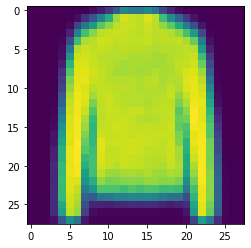

In [47]:
x_decoded = decoder.predict([[0, 0, 0, 0]])
plt.imshow(x_decoded[0,:,:,0] )
plt.show()

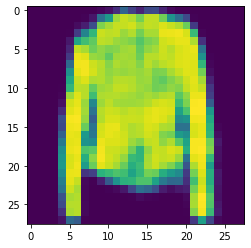

In [60]:
x_decoded = decoder.predict([[1, -2, -0.5, 2]])
plt.imshow(x_decoded[0,:,:,0] )
plt.show()

Хотя картинки тоже получаются достойные.

## Обзор статьи.

Оригинальный материал - препринт статьи о модели Flamingo от DeepMind:
https://storage.googleapis.com/deepmind-media/DeepMind.com/Blog/tackling-multiple-tasks-with-a-single-visual-language-model/flamingo.pdf

Обзор материала на русском языке - https://telegra.ph/Obzor-Flamingo--novoj-SOTA-v-zadache-zero-shot-visual-language-modeling-05-01

Я хочу сделать обзор Flamingo - новой модели для zero-shot visual-language modeling. В начале представлю краткий глоссарий, который мне пришлось составить, чтобы прочитать статью:


*   **Zero-shot learning** — это задача обучения модели решению задачи без предварительного обучения на размеченных данных
*   **Attention слой** - слой, который выявляет на основе обучающей выборки факторы, обращение внимания на которые снижает ошибку сети



Flamingo позволяет на основе примеров связок картинка/видео-текст строить описание картинок, или отвечать на вопросы по картинке или видео.

**Архитектура**

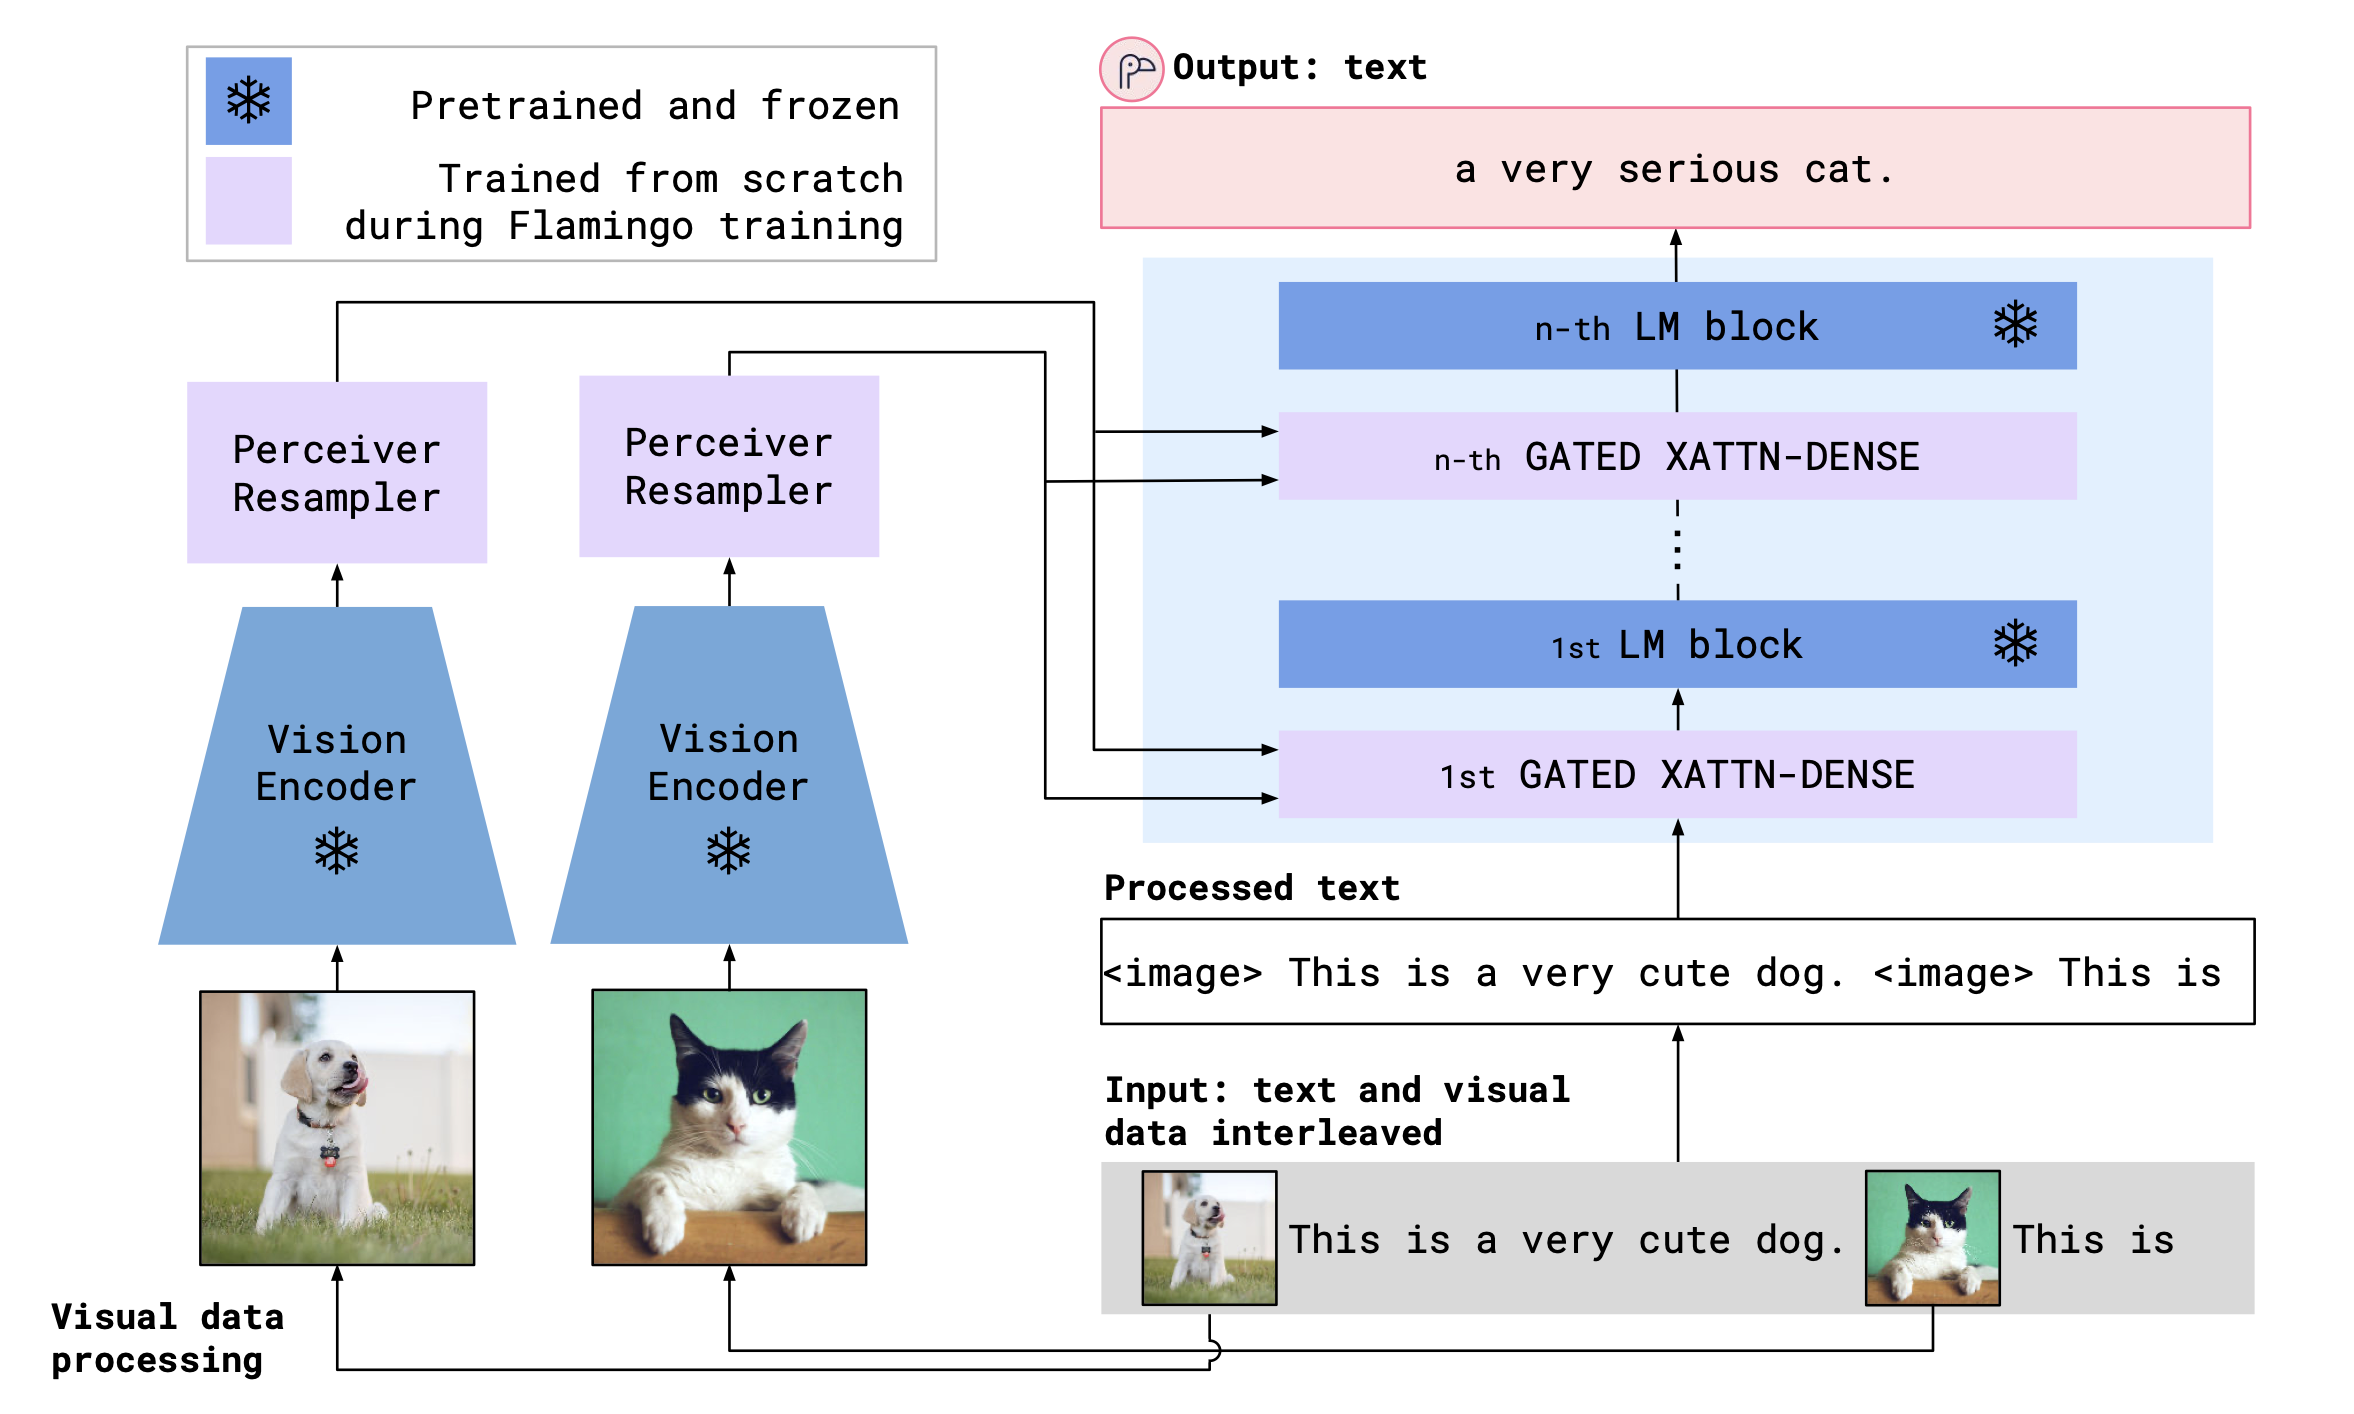

В Flamingo входы текста и картинок/видео разделены. Картинки поступают на предобученный Vision Encoder по архитектуре Normalizer-Free ResNet (NFNet). На его выходах эмбеддинги могут быть разного размера. Далее Perceiver Resampler превращает их в эмбеддинги одного размера.

Устройство Perceiver Resampler:
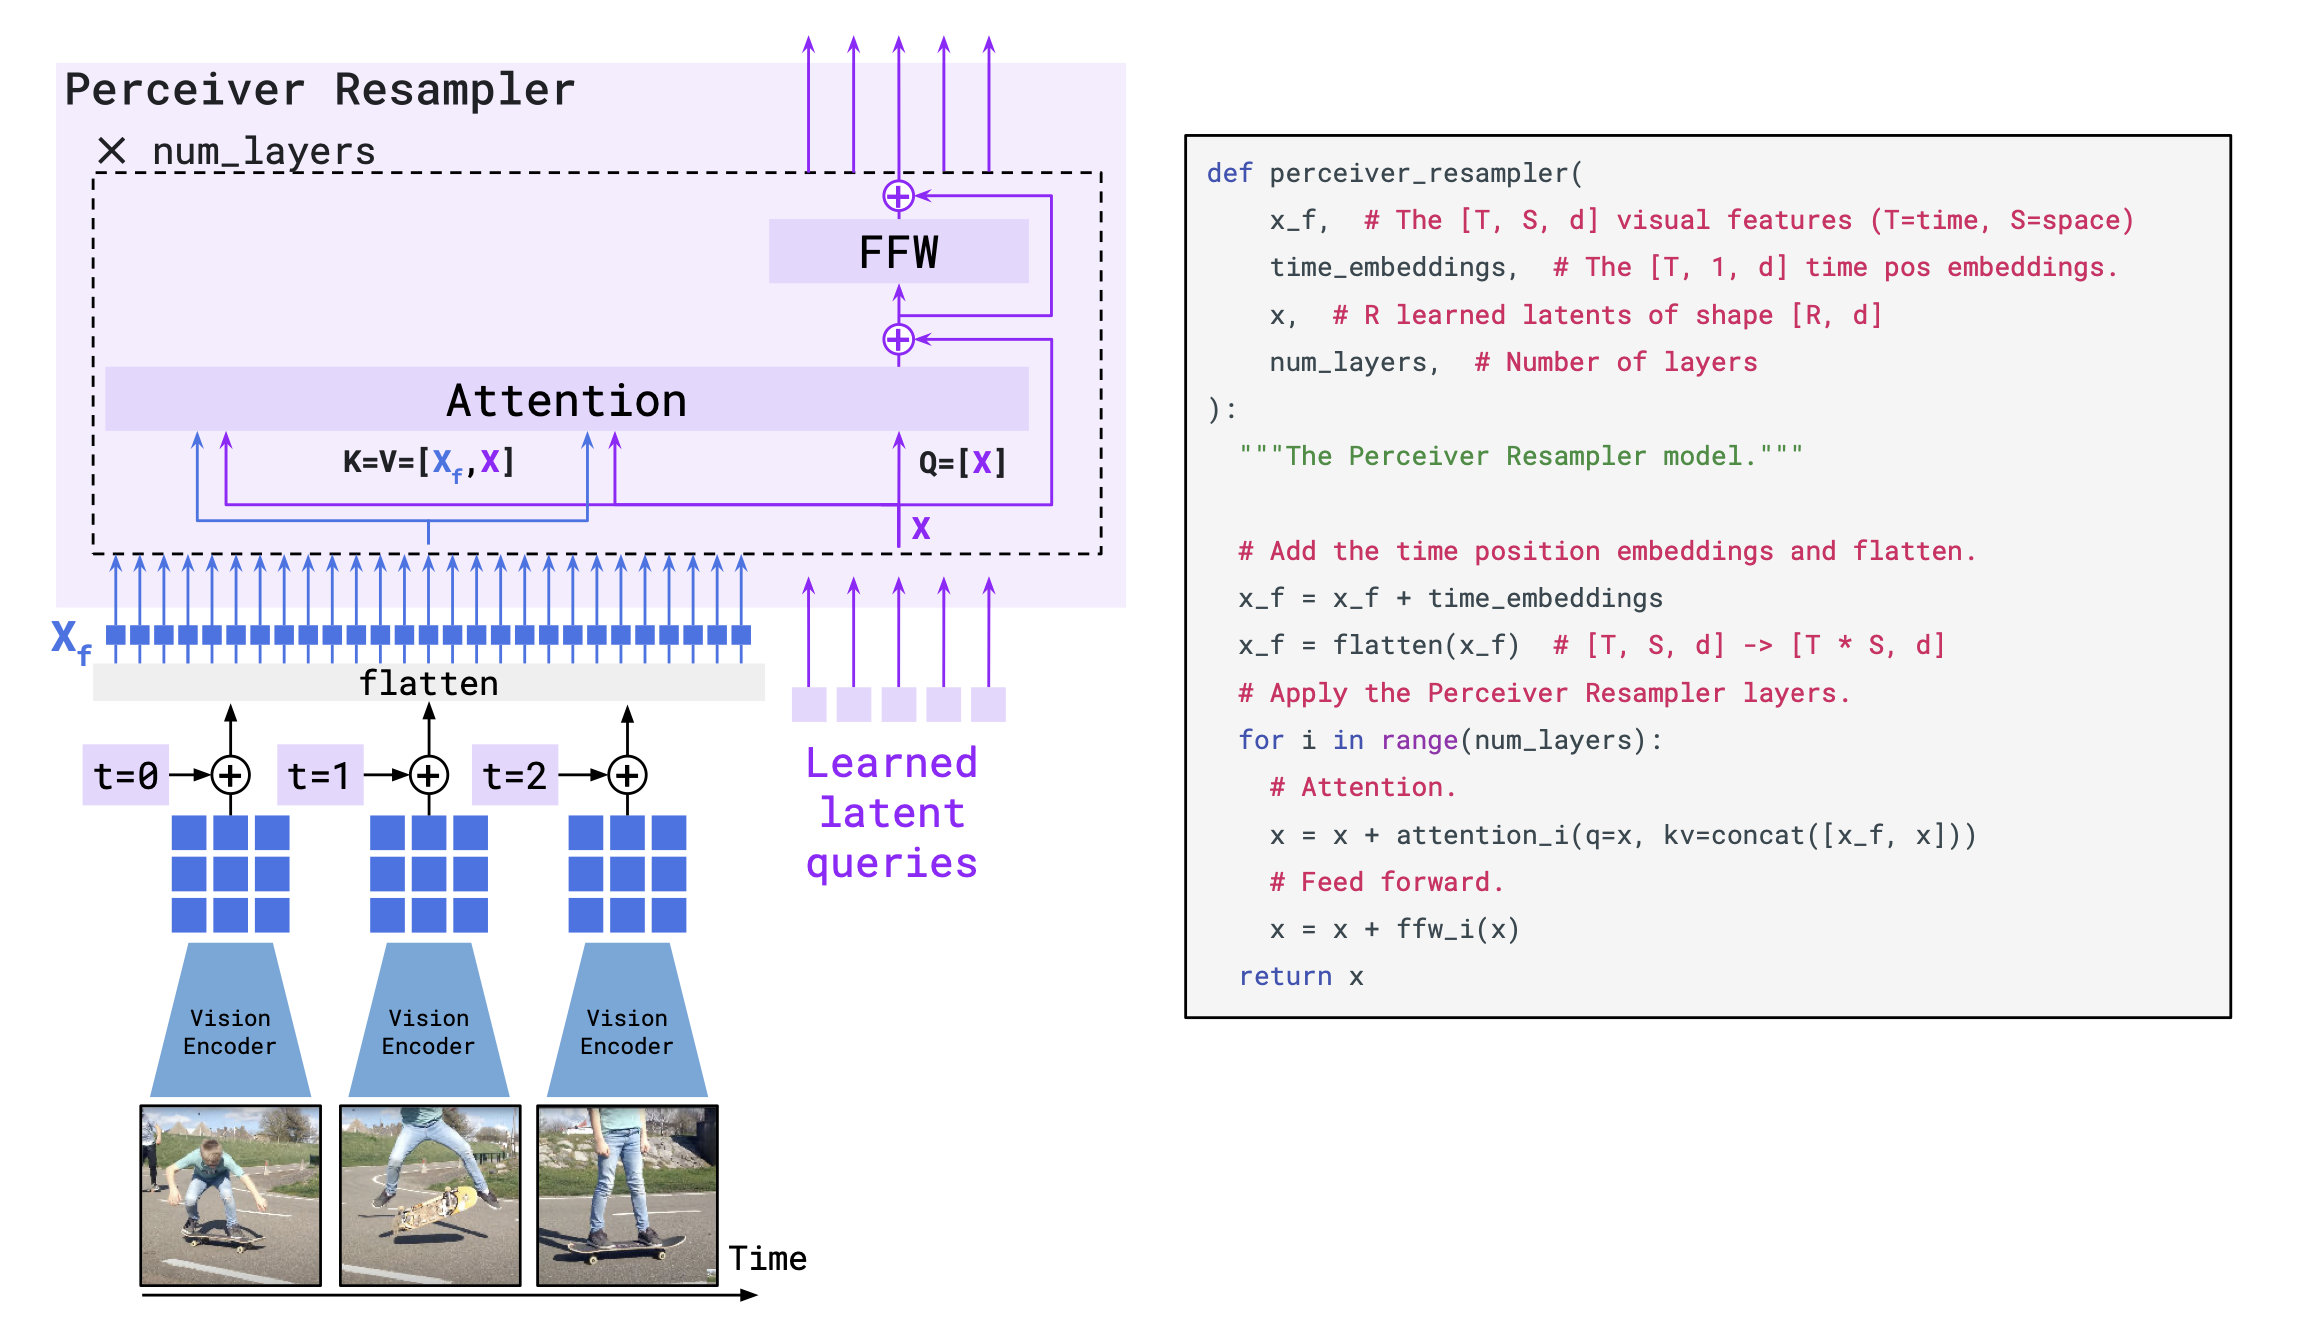

По сути, это полносносвязная нейронная сеть, но со слоем attention, которая позволяет включить в эмбеддинг те объекты, которые действительно важны.

Обработка текста происходит с помощью почти стандартной языковой модели.

**LM block** — блоки, взятые из предобученной языковой модели, которая обучалась только на текст. В процессе обучения Flamingo эти блоки заморожены и не обучаются.

**GATED XATTN-DENSE** — это блоки, вставленные между блоками LM, которые внедряют визуальную информацию, полученную из Perceiver Resampler, в языковую модель. По сути, это механизм обуславливания (conditioning) языковой модели на визуальную информацию из инпута.

Попробуем сравнить эту сеть с тем, что мы проходили на этом курсе.


*   ResNet и энкодер на его основе - по отдельности было, но ResNet в целом это прием для построения глубоких сетей, и на его основе можно строить что угодно.
*   Использование предобученных сетей как часть новой сети - было.


*   Attention - интересная альтернатива рекуррентным сетям в том числе. Как этот слой устроен и работает - этого не было.
*   Ну и также не было сложных языковых моделей-генераторов типа GPT

В целом, эта модель очень огромная и сложная, совмещает в себе много сущностей (картинки, видео, текст)
Про сложности применения можно предположить, что эта сеть будет долго отрабатывать.



